In [1]:
import pandas as pd
import numpy as np
import math
import random
import pickle
import torch

In [2]:
!nvidia-smi

Tue Mar 12 22:17:42 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.73.01    Driver Version: 460.73.01    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  TITAN Xp            Off  | 00000000:3B:00.0 Off |                  N/A |
| 23%   36C    P8     9W / 250W |   2521MiB / 12195MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  TITAN Xp            Off  | 00000000:AF:00.0 Off |                  N/A |
| 53%   

In [3]:
import sys, os
os.environ["CUDA_VISIBLE_DEVICES"]="1"

# Data Preparation

In [37]:
df = pd.read_csv("../Data (Reformatted)/df_mat_app_new.csv")

df = df[(df["mat"]!="unknown")].reset_index(drop=True)
df = df[(df["app"]!="unknown")].reset_index(drop=True)

df

,DOI,year,prompt,mat,app
0,10.1016/j.conbuildmat.2013.06.081,2013,### Instructions: Extract information about th...,coal bottom ash,fine aggregate
1,10.1016/j.conbuildmat.2012.07.078,2012,### Instructions: Extract information about th...,silica fume,supplementary cementitious material
2,10.1111/j.1551-2916.2007.02108.x,2007,### Instructions: Extract information about th...,Class C fly ash,supplementary cementitious material
3,10.1016/j.conbuildmat.2005.09.011,2005,### Instructions: Extract information about th...,coal fly ash,supplementary cementitious material
4,10.1016/j.conbuildmat.2011.06.019,2011,### Instructions: Extract information about th...,limestone powder,fine aggregate
...,...,...,...,...,...
4283,10.1016/j.resconrec.2012.12.003,2012,### Instructions: Extract information about th...,construction and demolition waste,supplementary cementitious material
4284,10.1016/j.conbuildmat.2020.119251,2020,### Instructions: Extract information about th...,construction and demolition waste,fine aggregate
4285,10.1016/j.resconrec.2006.05.010,2006,### Instructions: Extract information about th...,recycled aggregate,aggregate
4286,10.1016/j.jclepro.2018.03.085,2018,### Instructions: Extract information about th...,construction and demolition waste,supplementary cementitious material


# Load Model and Perform Embedding

In [5]:
import transformers
from transformers import AutoModelForCausalLM, AutoTokenizer

from peft import get_peft_config, get_peft_model, LoraConfig, TaskType

model_checkpoint = "EleutherAI/pythia-1b"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint, use_fast=True)

model = AutoModelForCausalLM.from_pretrained(model_checkpoint)

peft_config = LoraConfig(
        task_type=TaskType.CAUSAL_LM,
    )
model = get_peft_model(model, peft_config).to("cuda")

### grammar test

In [ ]:
input_ids = tokenizer("example sentence", return_tensors="pt").to("cuda")

outputs = model(**input_ids)
word_embedding = outputs[0].contiguous()
sentence_embedding = word_embedding[ :, -1, : ].contiguous()

In [ ]:
word_embedding.shape

In [ ]:
sentence_embedding.shape

## Pre-trained Pythia embeddings

In [6]:
embedding_records = []

for i in range(len(df)):
    if i%100 == 0:
        print(i)
    row = df.iloc[i]
    text = row["prompt"]
    input_ids = tokenizer(text, return_tensors="pt").to("cuda")
    
    outputs = model(**input_ids, output_hidden_states=True, use_cache=False)
    last_layer_hidden_states = outputs["hidden_states"][-1].contiguous().cpu().detach()
    paragraph_embedding = last_layer_hidden_states[ :, -1, : ].contiguous()
    
    record = {
        "mat": row["mat"],
        "app": row["app"],
        "paragraph_embedding": paragraph_embedding
    }
    
    embedding_records.append(record)


0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300


In [9]:
model = "pythia-1b"
version = "pretrained"

"""
my_dir = "/home/YD_large/NLP/embeddings/"
with open(my_dir + f'{model}_{version}.pkl', 'wb') as f:
    pickle.dump(embedding_records, f)
"""

In [10]:
embeddings = torch.cat([item["paragraph_embedding"] for item in embedding_records])

embeddings.shape

torch.Size([5368, 2048])

In [11]:
torch.save(embeddings, f"embeddings/{model}_{version}.pt")

# Low-dim Visualization & Clustering

In [12]:
model = "pythia-1b"
version = "pretrained"

embedddings = torch.load(f"embeddings/{model}_{version}.pt", weights_only=True)

In [13]:
from sklearn.manifold import TSNE
tSNE = TSNE(n_components=2, init='pca', random_state=50)
X_tSNE = tSNE.fit_transform(embeddings)

/home/synthesisproject/miniconda3/envs/yifei/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/home/synthesisproject/miniconda3/envs/yifei/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:996: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


In [14]:
print(X_tSNE.shape)

(5368, 2)


In [19]:
df_embed_tSNE = pd.DataFrame({'pc1': X_tSNE[:, 0], 'pc2': X_tSNE[:, 1]})

df_new = pd.concat([df, df_embed_tSNE], axis=1)

df_new

,DOI,year,prompt,mat,app,pc1,pc2
0,10.1016/j.conbuildmat.2013.06.081,2013,### Instructions: Extract information about th...,coal bottom ash,fine aggregate,0.707383,7.325620
1,10.1016/j.conbuildmat.2012.07.078,2012,### Instructions: Extract information about th...,silica fume,supplementary cementitious material,0.240330,6.914473
2,10.1111/j.1551-2916.2007.02108.x,2007,### Instructions: Extract information about th...,Class C fly ash,supplementary cementitious material,-4.953146,30.321560
3,10.1016/j.conbuildmat.2005.09.011,2005,### Instructions: Extract information about th...,coal fly ash,supplementary cementitious material,-0.237298,6.977503
4,10.1016/j.conbuildmat.2011.06.019,2011,### Instructions: Extract information about th...,limestone powder,fine aggregate,-8.690179,31.920820
...,...,...,...,...,...,...,...
5363,10.1016/j.resconrec.2012.12.003,2012,### Instructions: Extract information about th...,construction and demolition waste,supplementary cementitious material,32.305084,-22.951582
5364,10.1016/j.conbuildmat.2020.119251,2020,### Instructions: Extract information about th...,construction and demolition waste,fine aggregate,23.443670,26.711912
5365,10.1016/j.resconrec.2006.05.010,2006,### Instructions: Extract information about th...,recycled aggregate,aggregate,22.255568,10.582183
5366,10.1016/j.jclepro.2018.03.085,2018,### Instructions: Extract information about th...,construction and demolition waste,supplementary cementitious material,61.077885,-8.784804


## Group by APP

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

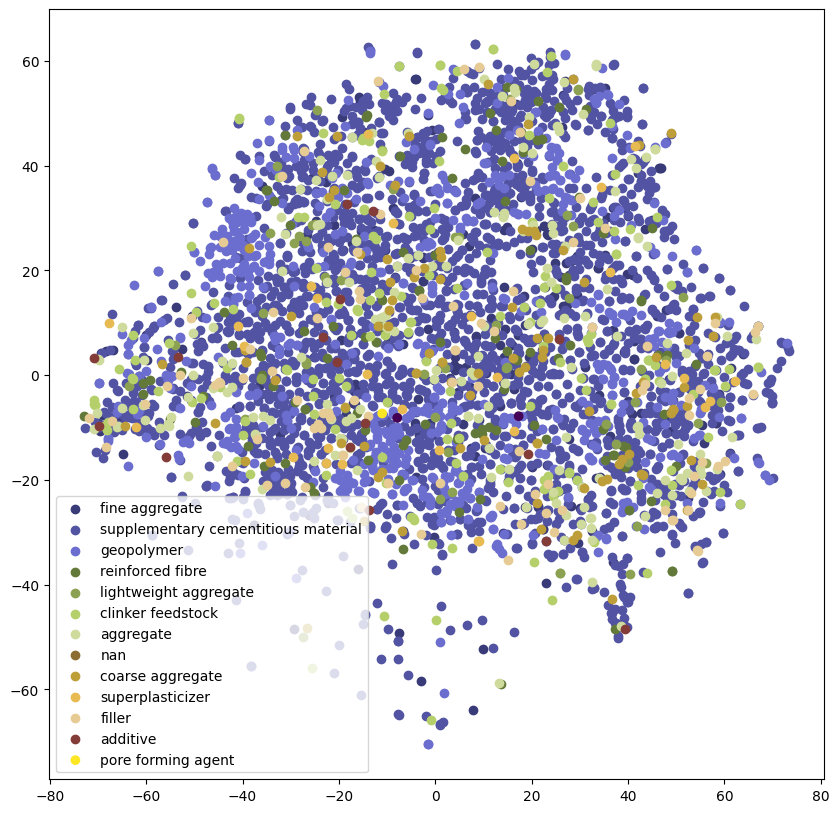

In [44]:
plt.figure(figsize=(10,10))
for i, APP in enumerate(df_new["app"].unique()):
    if APP=="unknown":
        continue
    df_sub = df_new[(df_new["app"]==APP)]
    plt.scatter(df_sub["pc1"], df_sub["pc2"], c=plt.cm.tab20b.colors[i], label=APP)
    
    """
    if APP in ["supplementary cementitious material", "fine aggregate", "coarse aggregate", 
               "geopolymer", "filler", "clinker feedstock"]:
        plt.scatter(df_sub["pc1"], df_sub["pc2"], c=plt.cm.tab20b.colors[i], label=APP)
    else:
        plt.scatter(df_sub["pc1"], df_sub["pc2"], c="grey")
    """

plt.legend()
plt.savefig("../Figs/Embeddings/"+ f"{model}_{version}_APP.jpg")
plt.show()

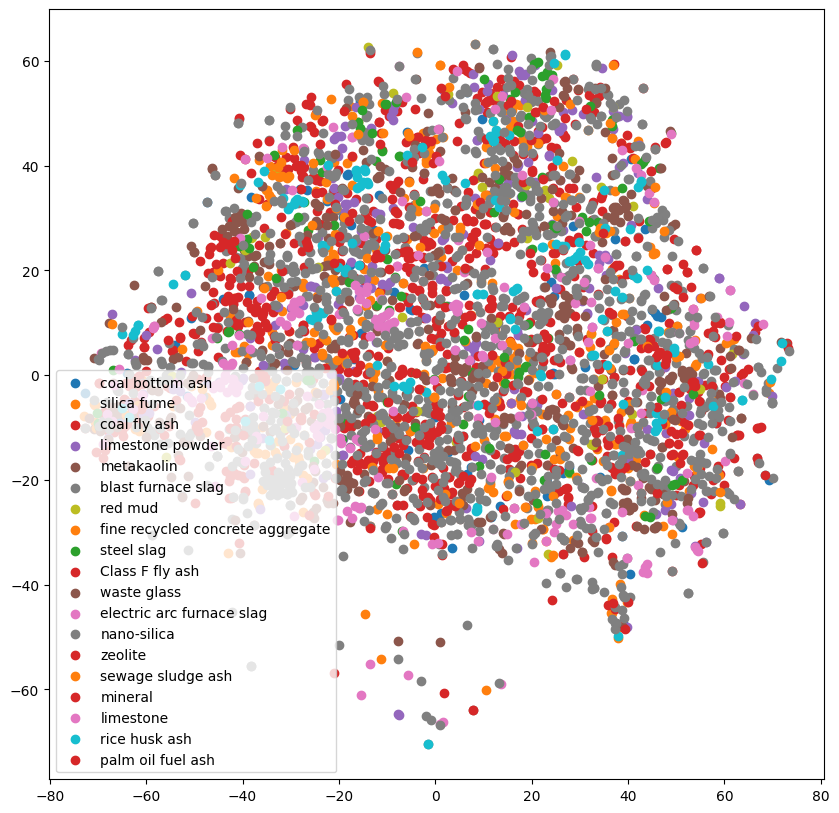

In [45]:
plt.figure(figsize=(10,10))
for i, MAT in enumerate(df_new["mat"].unique()):
    if MAT=="unknown":
        continue
    df_sub = df_new[(df_new["mat"]==MAT)]
    #plt.scatter(df_sub["pc1"], df_sub["pc2"], c=plt.cm.tab20b.colors[i], label=MAT)
    
    if len(df_sub)>50:
        plt.scatter(df_sub["pc1"], df_sub["pc2"], c=f"C{i}", label=MAT)
    else:
        plt.scatter(df_sub["pc1"], df_sub["pc2"], c="grey")
    

plt.legend()
plt.savefig("../Figs/Embeddings/"+ f"{model}_{version}_MAT.jpg")
plt.show()